# Data Prepration and Splits

In [2]:
import sys
print(sys.executable)


C:\Users\TTB\fresh_env\Scripts\python.exe


In [3]:
import sys
!{sys.executable} -m pip install --upgrade google-cloud-bigquery google-auth google-auth-oauthlib google-auth-httplib2 pandas-gbq


     ---------------------------------------- 0.0/253.1 kB ? eta -:--:--
     --------------------------------- ---- 225.3/253.1 kB 6.9 MB/s eta 0:00:01
     -------------------------------------- 253.1/253.1 kB 5.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/216.1 kB ? eta -:--:--
     ------------------------------------- 216.1/216.1 kB 12.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/81.3 kB ? eta -:--:--
     ---------------------------------------- 81.3/81.3 kB ? eta 0:00:00
     ---------------------------------------- 0.0/160.1 kB ? eta -:--:--
     ------------------------------------- 160.1/160.1 kB 10.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/181.3 kB ? eta -:--:--
     ------------------------------------- 181.3/181.3 kB 11.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/96.9 kB ? eta -:--:--
     ---------------------------------------- 96.9/96.9 kB ? eta 0:00:00
     -------------


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\TTB\fresh_env\Scripts\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account


In [2]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account

# Set paths and IDs
key_path = r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\Project_1\Pipeline files\GCS\sunlit-hook-455618-n1-c510f0cd5405.json"
project_id = "sunlit-hook-455618-n1"
table_path = "sunlit-hook-455618-n1.ed_data.sample_data"

# Authenticate and create client
credentials = service_account.Credentials.from_service_account_file(key_path)

# Query BigQuery table
query = f"SELECT * FROM `{table_path}`"
df = pd.read_gbq(query, project_id=project_id, credentials=credentials, dialect="standard")

# Preview loaded data
print("Data loaded from BigQuery:")
display(df.head())


C:\Users\TTB\AppData\Local\Temp\ipykernel_29748\3581779747.py:15: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query, project_id=project_id, credentials=credentials, dialect="standard")


Data loaded from BigQuery:


,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,triage_temperature,...,vs_heartrate,vs_charttime,med_name,med_gsn,med_ndc,med_description,med_charttime,pyxis_name,pyxis_gsn,pyxis_charttime
0,10021487,28998349.0,38319705,2116-12-02 22:57:00+00:00,2116-12-03 01:02:00+00:00,M,WHITE,AMBULANCE,ADMITTED,NaN,...,NaN,NaT,None,<NA>,<NA>,None,NaT,PHENYLEPHRINE,5066.0,2116-12-03 00:23:00+00:00
1,10004235,24181354.0,38926302,2196-02-24 12:15:00+00:00,2196-02-24 17:07:00+00:00,M,MULTIPLE RACE/ETHNICITY,AMBULANCE,ADMITTED,NaN,...,NaN,NaT,None,<NA>,<NA>,None,NaT,EPINEPHRINE (FOR DILUTION),62006.0,2196-02-24 14:42:00+00:00
2,10021487,28998349.0,38319705,2116-12-02 22:57:00+00:00,2116-12-03 01:02:00+00:00,M,WHITE,AMBULANCE,ADMITTED,NaN,...,NaN,NaT,None,<NA>,<NA>,None,NaT,PROPOFOL,65888.0,2116-12-02 23:48:00+00:00
3,10022257,NaN,31940867,2167-06-07 16:23:00+00:00,2167-06-07 17:29:00+00:00,M,WHITE,UNKNOWN,ELOPED,96.9,...,NaN,NaT,None,<NA>,<NA>,None,NaT,None,NaN,NaT
4,10021487,28998349.0,38319705,2116-12-02 22:57:00+00:00,2116-12-03 01:02:00+00:00,M,WHITE,AMBULANCE,ADMITTED,NaN,...,NaN,NaT,None,<NA>,<NA>,None,NaT,PHENYLEPHRINE,5068.0,2116-12-03 00:24:00+00:00


In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Ensure datetime columns are parsed
if 'intime' in df.columns:
    df['intime'] = pd.to_datetime(df['intime'], errors='coerce')
if 'outtime' in df.columns:
    df['outtime'] = pd.to_datetime(df['outtime'], errors='coerce')

# Step 2: Split by unique subject_id
unique_subjects = df['subject_id'].unique()
train_ids, temp_ids = train_test_split(unique_subjects, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Step 3: Create data splits
train_df = df[df['subject_id'].isin(train_ids)].copy()
val_df = df[df['subject_id'].isin(val_ids)].copy()
test_df = df[df['subject_id'].isin(test_ids)].copy()

# Step 4: Function to compute statistics
def compute_split_stats(name, split_df):
    stats = {
        "Split": name,
        "Total Rows": len(split_df),
        "Unique Subjects": split_df['subject_id'].nunique(),
    }
    if 'gender' in split_df.columns:
        stats["% Female"] = round((split_df['gender'] == 'F').mean() * 100, 2)
        stats["% Male"] = round((split_df['gender'] == 'M').mean() * 100, 2)
    if 'race' in split_df.columns and not split_df['race'].isna().all():
        stats["Most Common Race"] = split_df['race'].mode().values[0]
    if 'arrival_transport' in split_df.columns and not split_df['arrival_transport'].isna().all():
        stats["Arrival Mode"] = split_df['arrival_transport'].mode().values[0]
    if 'vs_temperature' in split_df.columns:
        stats["Avg Temperature"] = round(split_df['vs_temperature'].mean(), 2)
    if 'icd_title' in split_df.columns and not split_df['icd_title'].isna().all():
        stats["Top ICD Diagnosis"] = split_df['icd_title'].mode().values[0]
    
    return stats

# Step 5: Generate and display summary DataFrame
split_summary = pd.DataFrame([
    compute_split_stats("Train", train_df),
    compute_split_stats("Validation", val_df),
    compute_split_stats("Test", test_df)
])

print("=== Split Summary ===")
display(split_summary)


=== Split Summary ===


,Split,Total Rows,Unique Subjects,% Female,% Male,Most Common Race,Arrival Mode,Avg Temperature,Top ICD Diagnosis
0,Train,556459,350,49.87,50.13,WHITE,AMBULANCE,97.24,ESSENTIAL (PRIMARY) HYPERTENSION
1,Validation,86144,75,60.81,39.19,WHITE,WALK IN,96.83,HEART VALVE REPLAC NEC
2,Test,74775,75,62.94,37.06,WHITE,WALK IN,98.03,"DYSPNEA, UNSPECIFIED"


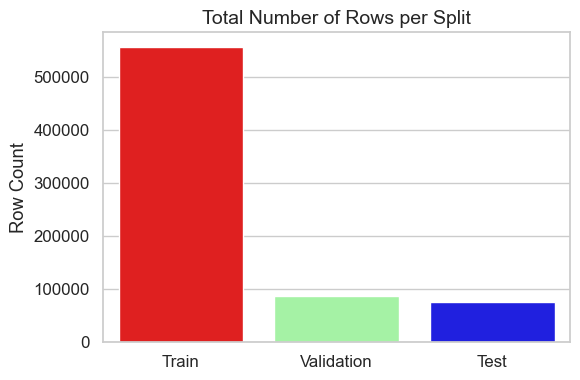

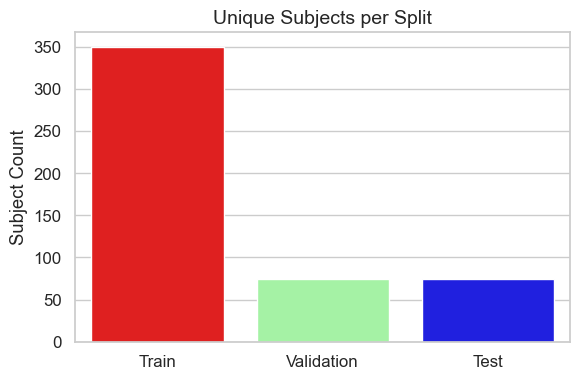

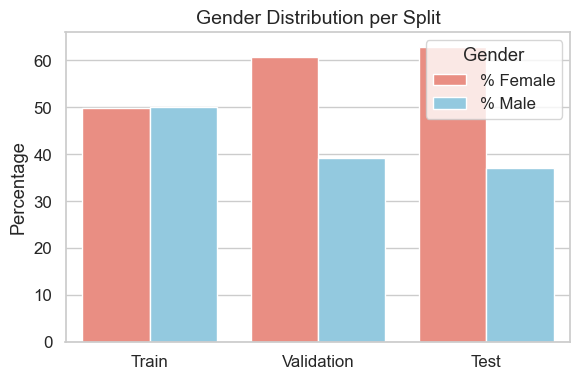

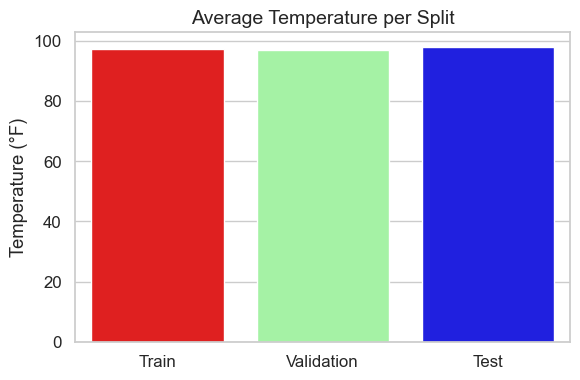

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define consistent color mapping
split_palette = {
    "Train": "red",
    "Validation": "#98FF98",  # mint green
    "Test": "blue"
}

sns.set(style="whitegrid", font_scale=1.1)

# === Total Rows Barplot ===
if "Total Rows" in split_summary.columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=split_summary, x="Split", y="Total Rows", hue="Split", 
                palette=split_palette, dodge=False)
    plt.title("Total Number of Rows per Split", fontsize=14)
    plt.ylabel("Row Count")
    plt.xlabel("")
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()

# === Unique Subjects Barplot ===
if "Unique Subjects" in split_summary.columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=split_summary, x="Split", y="Unique Subjects", hue="Split", 
                palette=split_palette, dodge=False)
    plt.title("Unique Subjects per Split", fontsize=14)
    plt.ylabel("Subject Count")
    plt.xlabel("")
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()

# === Gender Distribution Barplot ===
if "% Female" in split_summary.columns and "% Male" in split_summary.columns:
    gender_df = split_summary[["Split", "% Female", "% Male"]].melt(
        id_vars="Split", var_name="Gender", value_name="Percentage"
    )
    plt.figure(figsize=(6, 4))
    sns.barplot(data=gender_df, x="Split", y="Percentage", hue="Gender",
                palette={"% Female": "salmon", "% Male": "skyblue"})
    plt.title("Gender Distribution per Split", fontsize=14)
    plt.ylabel("Percentage")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

# === Avg Temperature Barplot ===
if "Avg Temperature" in split_summary.columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=split_summary, x="Split", y="Avg Temperature", hue="Split",
                palette=split_palette, dodge=False)
    plt.title("Average Temperature per Split", fontsize=14)
    plt.ylabel("Temperature (°F)")
    plt.xlabel("")
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()
